### Praktische Anwendung von DoubleML auf den Lalonde-Datensatz

In [ ]:
# Notwendige Bibliotheken importieren
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression, LogisticRegressionCV
from doubleml import DoubleMLIRM, DoubleMLData
from doubleml.utils.resampling import DoubleMLResampling
from sklearn.model_selection import cross_val_predict
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
import sys, os
# hier den Pfad zur Funktion pscore_discard aus functions.py einfügen
sys.path.append(os.path.abspath("."))
from functions import pscore_discard
import warnings
warnings.filterwarnings("ignore")

In [ ]:
# NSW-Daten einlesen - Quelle: https://users.nber.org/~rdehejia/data/.nswdata2.html
l_tr = pd.read_csv("Code/Lalonde/Daten/nsw_treated.txt", sep='\\s+', header=None)  #297
l_co = pd.read_csv("Code/Lalonde/Daten/nsw_control.txt", sep='\\s+', header=None)  #425
spaltenname = ['treat', 'age', 'education', 'black', 'hispanic', 'married', 'nodegree', 're75', 're78']
l_tr.columns = spaltenname
l_co.columns = spaltenname
# Arbeitslosenstatus für das Jahr 1975 hinzufügen
l_tr['u75'] = np.where(l_tr['re75'] == 0, 1, 0)
l_co['u75'] = np.where(l_co['re75'] == 0, 1, 0)
l = pd.concat([l_tr, l_co]).reset_index(drop=True) #722


In [ ]:
# nicht-experimentelle Vergleichsgruppen aus CPS und PSID einlesen
cps_co = pd.read_csv("Code/Lalonde/Daten/cps_controls.txt", sep='\\s+', header=None)  #15992
psid_co = pd.read_csv("Code/Lalonde/Daten/psid_controls.txt", sep='\\s+', header=None)  #2490
spaltenname = ['treat', 'age', 'education', 'black', 'hispanic', 'married', 'nodegree', 're74', 're75', 're78']
cps_co.columns = spaltenname
psid_co.columns = spaltenname
# Arbeitslosenstatus für die Jahre 1974 und 1975 hinzufügen
cps_co['u74'] = np.where(cps_co['re74'] == 0, 1, 0)
cps_co['u75'] = np.where(cps_co['re75'] == 0, 1, 0)
psid_co['u74'] = np.where(psid_co['re74'] == 0, 1, 0)
psid_co['u75'] = np.where(psid_co['re75'] == 0, 1, 0)

In [ ]:
# Lalonde-CPS-Daten und Lalonde-PSID-Daten zusammenführen
l_cps = pd.concat([l_tr, cps_co]).reset_index(drop=True).drop(columns=['re74', 'u74'])
l_psid = pd.concat([l_tr, psid_co]).reset_index(drop=True).drop(columns=['re74', 'u74'])

### Lalonde-Datensatzes für männliche Teilnehmende

### Verteilung der Kovariaten

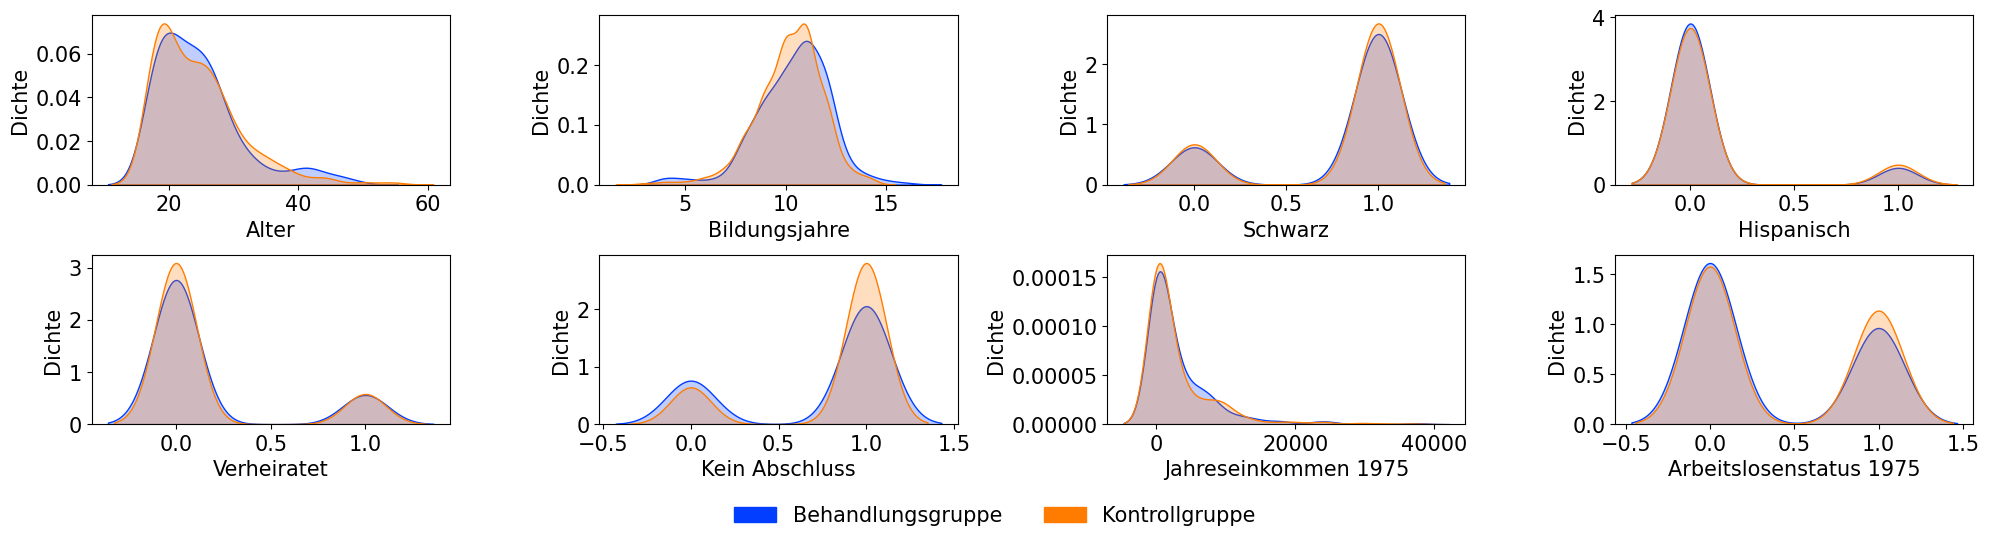

In [11]:
# Kovariaten und Behandlungsvariable extrahieren
l_d = l.treat
l_X = l[["age", "education", "black", "hispanic", "married", "nodegree", "re75", "u75"]]

# Subplots erstellen
fig, axs = plt.subplots(2, 4, figsize=(20,5))
axs = axs.flatten() 

# Farben aus der 'bright'-Palette extrahieren
colors = sns.color_palette('bright')

# Dichteverteilung der Kovariaten in den Lalonde-CPS-Daten plotten
for i, covariate in enumerate(l_X.columns):
    sns.kdeplot(l[l['treat'] == 1][covariate], ax=axs[i], fill=True, color=colors[0],  legend=False)
    sns.kdeplot(l[l['treat'] == 0][covariate], ax=axs[i], fill=True, color=colors[1],  legend=False)
    axs[i].set_ylabel('Dichte', fontsize=15)

    # Schriftgröße der Achsenwerte anpassen
    axs[i].tick_params(axis='both', labelsize=15)

    # Beschriftungen der X-Achse umbenennen
    if i == 0:
        axs[i].set_xlabel('Alter', fontsize=15)
    if i == 1:
        axs[i].set_xlabel('Bildungsjahre', fontsize=15)
    if i == 2:
        axs[i].set_xlabel('Schwarz', fontsize=15)     
    if i == 3:
        axs[i].set_xlabel('Hispanisch', fontsize=15)   
    if i == 4:
        axs[i].set_xlabel('Verheiratet', fontsize=15)
    if i == 5:
        axs[i].set_xlabel('Kein Abschluss', fontsize=15)
    if i == 6:
        axs[i].set_xlabel('Jahreseinkommen 1975', fontsize=15)
    if i == 7:
        axs[i].set_xlabel('Arbeitslosenstatus 1975', fontsize=15)

# Manuelle Legende erstellen
handles = [
    Patch(color=colors[0], label='Behandlungsgruppe'),
    Patch(color=colors[1], label='Kontrollgruppe')] 

# Legende korrekt platzieren
fig.legend(handles=handles, loc='lower center', fontsize=15, bbox_to_anchor=(0.5, -0.1), ncols=2, frameon=False)

# Layout anpassen
plt.tight_layout()
plt.show()

Die Verteilung der Kovariaten der beiden Gruppen sieht ähnlich aus.

In [12]:
# Mittelwerte der Kovariaten in den beiden Gruppen berechnen
l.groupby(['treat']).mean()

,age,education,black,hispanic,married,nodegree,re75,re78,u75
treat,,,,,,,,,
0.0,24.447059,10.188235,0.800000,0.112941,0.157647,0.814118,3026.682743,5090.048302,0.418824
1.0,24.626263,10.380471,0.801347,0.094276,0.168350,0.730640,3066.098187,5976.352033,0.373737


In [13]:
# Benchmark berechnen
benchmark = l.groupby(['treat']).mean()['re78'][1] - l.groupby(['treat']).mean()['re78'][0]
benchmark

886.3037307037439

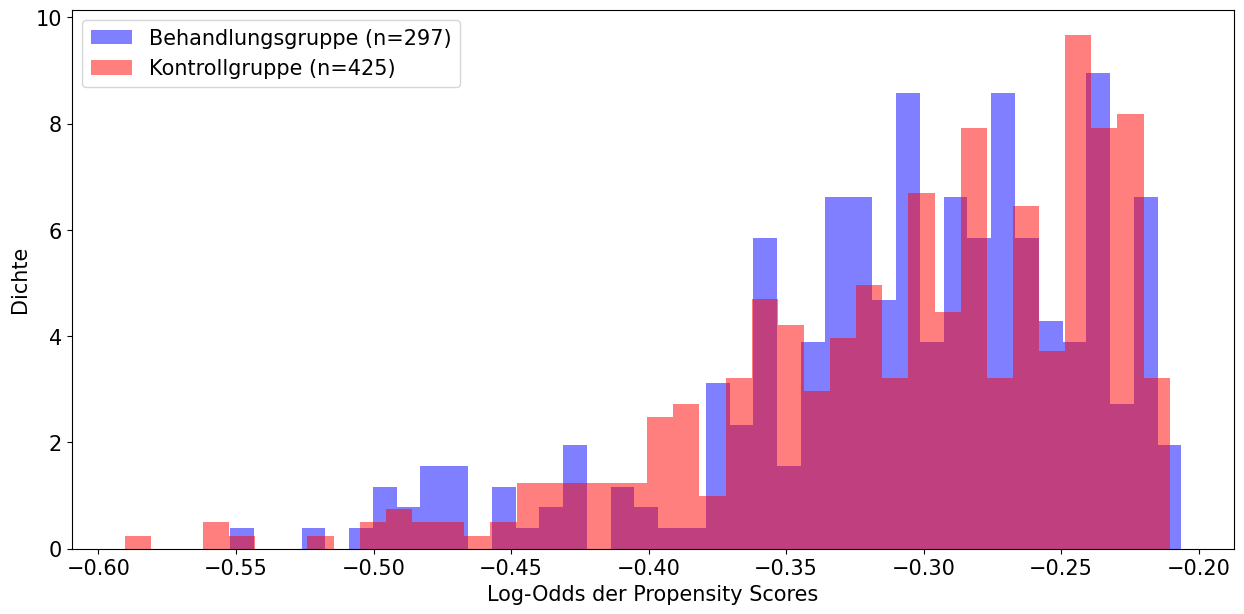

In [14]:
# Seed für die Reproduzierbarkeit festlegen
np.random.seed(1234)

# Propensity Scores mittels logistischer Regression mit Kreuzvalidierung schätzen
logistic_model = LogisticRegressionCV()
logistic_model.fit(X=l_X, y=l_d)
l['ps_lr'] = logistic_model.predict_proba(l_X)[:, 1]
# Log-Odds der Propensity Scores berechnen
l['log_odds_ps_lr'] = np.log(l['ps_lr'] / (1 - l['ps_lr']))

# Anzahl der Beobachtungen in der Behandlungs- und Kontrollgruppe berechnen
count_treated = l.loc[l['treat'] == 1].shape[0]
count_untreated = l.loc[l['treat'] == 0].shape[0]

# Dichteverteilung von Log-Odds der Propensity Scores der Behandlungs- und Kontrollgruppe in den Lalonde-Daten plotten
plt.figure(figsize=(15, 7))
plt.hist(l[l['treat'] == 1]['log_odds_ps_lr'], bins=40, alpha=0.5, color='blue', label=f'Behandlungsgruppe (n={count_treated})', density=True)
plt.hist(l[l['treat'] == 0]['log_odds_ps_lr'], bins=40, alpha=0.5, color='red', label=f'Kontrollgruppe (n={count_untreated})', density=True)
plt.xlabel('Log-Odds der Propensity Scores', fontsize=15)
plt.ylabel('Dichte', fontsize=15)
# Schriftgröße der Achsenwerte anpassen
plt.tick_params(axis='both', labelsize=15)
plt.legend(fontsize=15, loc='upper left')
plt.show()

### Lalonde-CPS-Datensatz: Verteilungen der Kovariaten

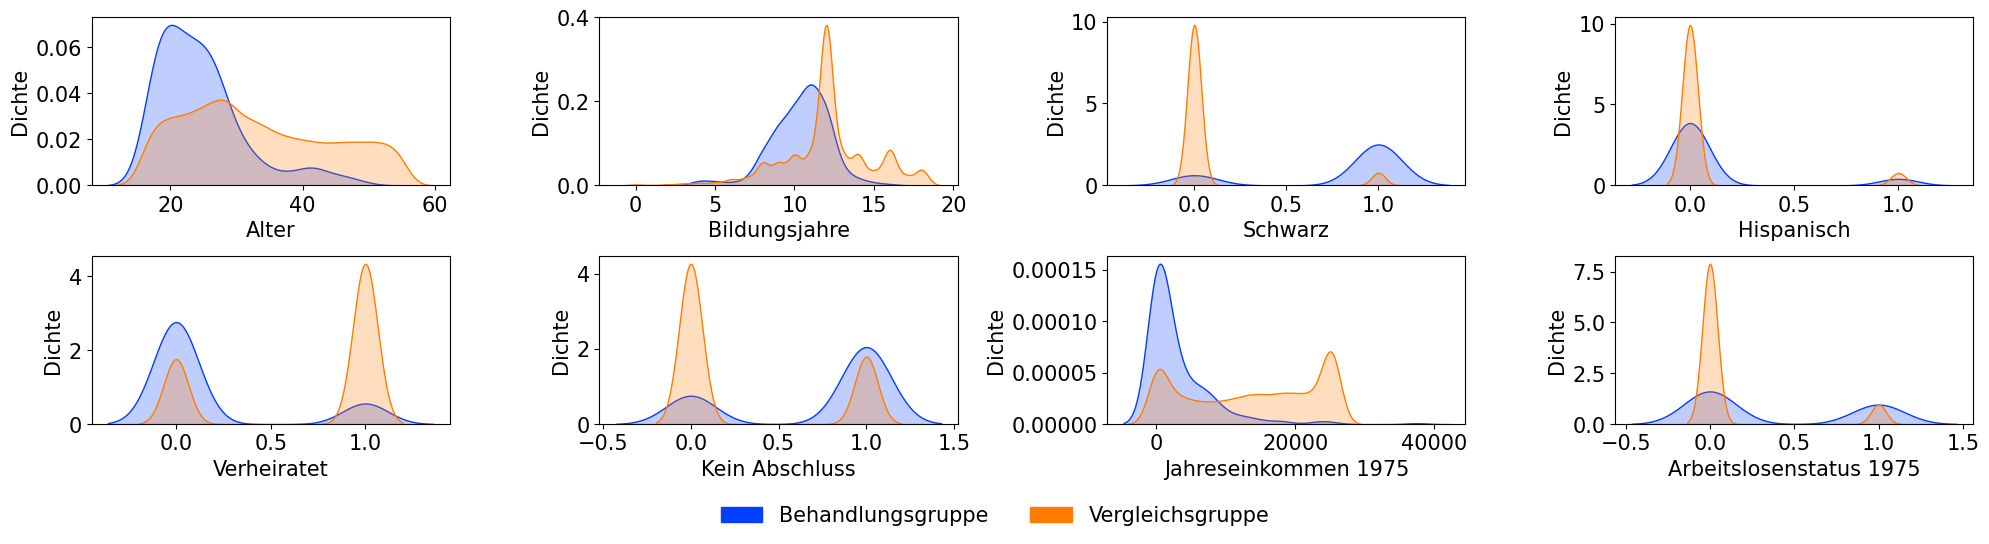

In [15]:
# Kovariaten in den Lalonde-CPS-Daten auswählen
l_cps_X = l_cps[["age", "education", "black", "hispanic", "married","nodegree", "re75", "u75"]]

# Subplots erstellen
fig, axs = plt.subplots(2, 4, figsize=(20,5))
axs = axs.flatten() 

# Farben aus der 'bright'-Palette extrahieren
colors = sns.color_palette('bright')

# Dichteverteilung der Kovariaten in der Lalonde-CPS-Daten plotten
for i, covariate in enumerate(l_cps_X.columns):
    sns.kdeplot(l_cps[l_cps['treat'] == 1][covariate], ax=axs[i], fill=True, color=colors[0],  legend=False)
    sns.kdeplot(l_cps[l_cps['treat'] == 0][covariate], ax=axs[i], fill=True, color=colors[1],  legend=False)

    # Schriftgröße der Achsenticks anpassen
    axs[i].tick_params(axis='both', labelsize=15)
    axs[i].set_ylabel('Dichte', fontsize=15)
    
    # Beschriftungen der X-Achse umbenennen
    if i == 0:
        axs[i].set_xlabel('Alter', fontsize=15)
    if i == 1:
        axs[i].set_xlabel('Bildungsjahre', fontsize=15)
    if i == 2:
        axs[i].set_xlabel('Schwarz', fontsize=15)     
    if i == 3:
        axs[i].set_xlabel('Hispanisch', fontsize=15)   
    if i == 4:
        axs[i].set_xlabel('Verheiratet', fontsize=15)
    if i == 5:
        axs[i].set_xlabel('Kein Abschluss', fontsize=15)
    if i == 6:
        axs[i].set_xlabel('Jahreseinkommen 1975', fontsize=15)    
    if i == 7:
        axs[i].set_xlabel('Arbeitslosenstatus 1975', fontsize=15)

# Manuelle Legende erstellen
handles = [
    Patch(color=colors[0], label='Behandlungsgruppe'),
    Patch(color=colors[1], label='Vergleichsgruppe')] 

# Legende korrekt platzieren
fig.legend(handles=handles, loc='lower center', fontsize=15, bbox_to_anchor=(0.5, -0.1), ncols=2, frameon=False)

# Layout anpassen
plt.tight_layout()
plt.show()

In [16]:
# Mittelwerte der Kovariaten in den beiden Gruppen berechnen
l_cps.groupby(['treat']).mean()

,age,education,black,hispanic,married,nodegree,re75,re78,u75
treat,,,,,,,,,
0.0,33.225238,12.027514,0.073537,0.072036,0.711731,0.295835,13650.803376,14846.659673,0.109305
1.0,24.626263,10.380471,0.801347,0.094276,0.168350,0.730640,3066.098187,5976.352033,0.373737


In [17]:
# Trainingseffekt ohne der Adjustierung mit den Lalonde-CPS-Daten berechnen
l_cps.groupby(['treat']).mean()['re78'][1] - l_cps.groupby(['treat']).mean()['re78'][0]

-8870.307640179994

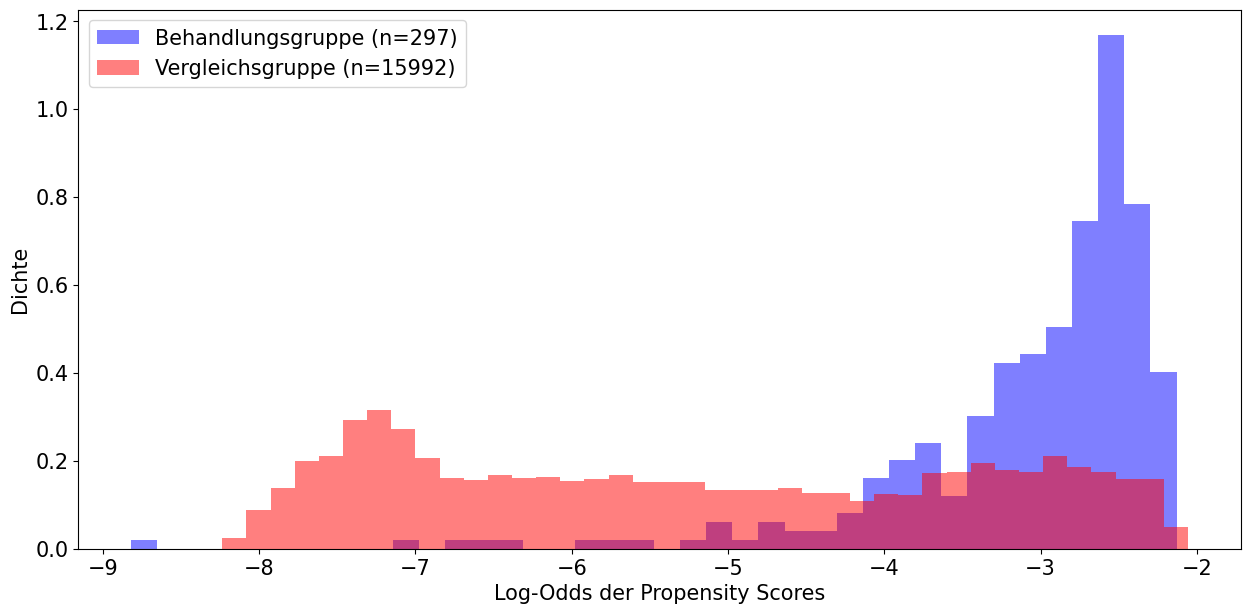

In [18]:
# Seed für die Reproduzierbarkeit festlegen
np.random.seed(1234)

# Kovariaten in den Lalonde-CPS-Daten auswählen
l_cps_d = l_cps.treat
l_cps_X = l_cps[["age", "education", "black", "hispanic", "married","nodegree", "re75", "u75"]]

# Propensity Scores mittels logistischer Regression mit Kreuzvalidierung schätzen
logistic_model = LogisticRegressionCV()
logistic_model.fit(l_cps_X, l_cps_d)
l_cps['ps_lr'] = logistic_model.predict_proba(l_cps_X)[:, 1]
# Log-Odds der Propensity Scores berechnen
l_cps['log_odds_ps_lr'] = np.log(l_cps['ps_lr'] / (1 - l_cps['ps_lr']))

# Anzahl der Beobachtungen in der Behandlungs- und Kontrollgruppe berechnen
count_treated = l_cps.loc[l_cps['treat'] == 1].shape[0]
count_untreated = l_cps.loc[l_cps['treat'] == 0].shape[0]

# Dichteverteilung der Log-Odds der Propensity Scores in den beiden Gruppen plotten
plt.figure(figsize=(15, 7))
plt.hist(l_cps[l_cps['treat'] == 1]['log_odds_ps_lr'], bins=40, alpha=0.5, color='blue', label=f'Behandlungsgruppe (n={count_treated})', density=True)
plt.hist(l_cps[l_cps['treat'] == 0]['log_odds_ps_lr'], bins=40, alpha=0.5, color='red', label=f'Vergleichsgruppe (n={count_untreated})', density=True)
plt.xlabel('Log-Odds der Propensity Scores', fontsize=15)
plt.ylabel('Dichte', fontsize=15)
# Schriftgröße der Achsenticks anpassen
plt.tick_params(axis='both', labelsize=15)
plt.legend(fontsize=15, loc='upper left')
plt.show()

### Lalonde-PSID-Daten: Verteilungen der Kovariaten

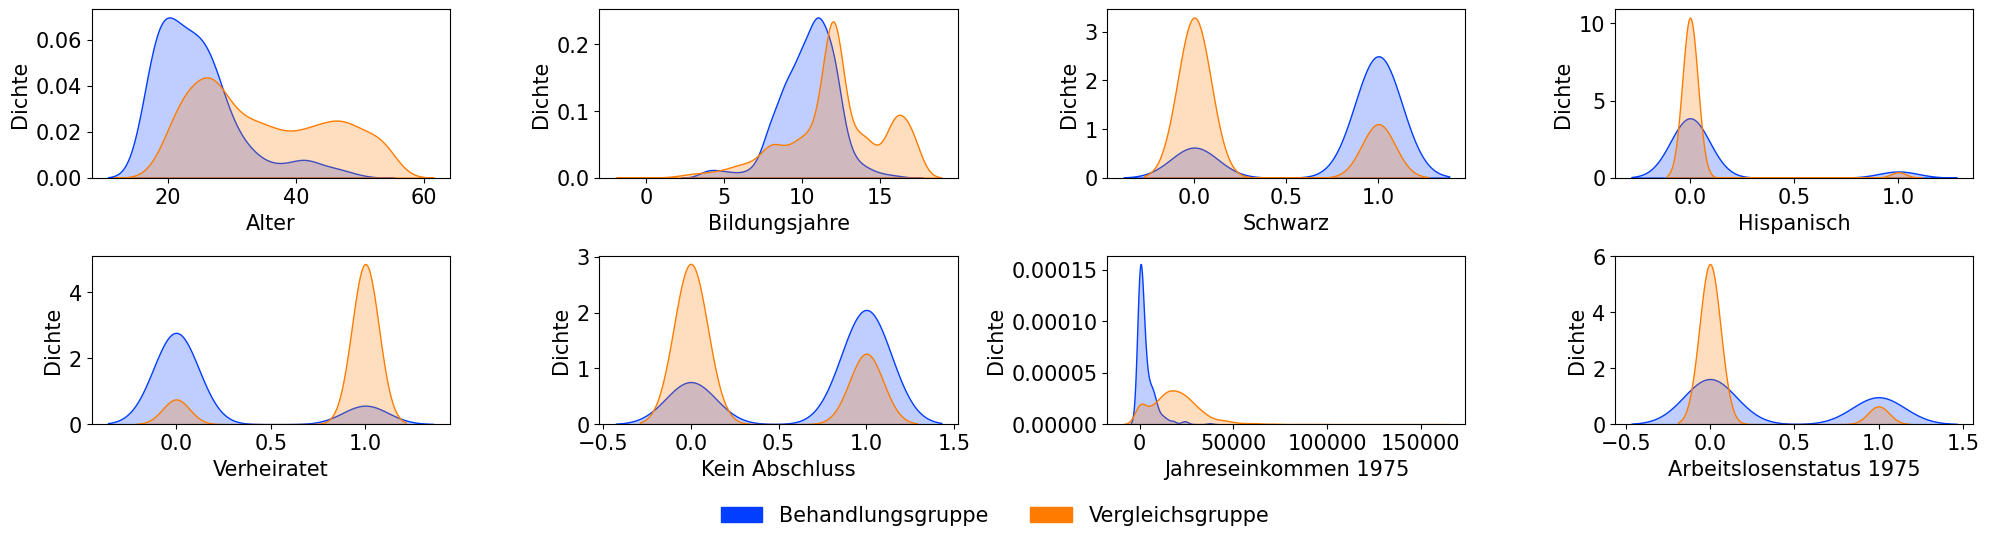

In [19]:
# Kovariaten in den Lalonde-PSID-Daten auswählen
l_psid_X = l_psid[["age", "education", "black", "hispanic", "married","nodegree", "re75", "u75"]]

# Subplots erstellen
fig, axs = plt.subplots(2, 4, figsize=(20, 5))
axs = axs.flatten() 

# Farben aus der 'bright'-Palette extrahieren
colors = sns.color_palette('bright')

# Dichteverteilung der Kovariaten in den Lalonde-PSID-Daten plotten
for i, covariate in enumerate(l_psid_X.columns):
    sns.kdeplot(l_psid[l_psid['treat'] == 1][covariate], ax=axs[i], fill=True, color=colors[0],  legend=False)
    sns.kdeplot(l_psid[l_psid['treat'] == 0][covariate], ax=axs[i], fill=True, color=colors[1],  legend=False)
    
    # Schriftgröße der Achsenticks anpassen
    axs[i].tick_params(axis='both', labelsize=15)
    axs[i].set_ylabel('Dichte', fontsize=15)
    # Beschriftungen der X-Achse umbenennen
    if i == 0:
        axs[i].set_xlabel('Alter', fontsize=15)
    if i == 1:
        axs[i].set_xlabel('Bildungsjahre', fontsize=15)
    if i == 2:
        axs[i].set_xlabel('Schwarz', fontsize=15)     
    if i == 3:
        axs[i].set_xlabel('Hispanisch', fontsize=15)   
    if i == 4:
        axs[i].set_xlabel('Verheiratet', fontsize=15)
    if i == 5:
        axs[i].set_xlabel('Kein Abschluss', fontsize=15)
    if i == 6:
        axs[i].set_xlabel('Jahreseinkommen 1975', fontsize=15)
    if i == 7:
        axs[i].set_xlabel('Arbeitslosenstatus 1975', fontsize=15)

# Manuelle Legende erstellen
handles = [
    Patch(color=colors[0], label='Behandlungsgruppe'),
    Patch(color=colors[1], label='Vergleichsgruppe')]

# Legende korrekt platzieren
fig.legend(handles=handles, loc='lower center', fontsize=15, bbox_to_anchor=(0.5, -0.1), ncols=2, frameon=False)

# Layout anpassen
plt.tight_layout()
plt.show()

In [20]:
# Mittelwerte der Kovariaten in den beiden Gruppen berechnen
l_psid.groupby(['treat']).mean()

,age,education,black,hispanic,married,nodegree,re75,re78,u75
treat,,,,,,,,,
0.0,34.850602,12.116867,0.250602,0.032530,0.866265,0.305221,19063.337587,21553.920998,0.100000
1.0,24.626263,10.380471,0.801347,0.094276,0.168350,0.730640,3066.098187,5976.352033,0.373737


In [21]:
# Trainingseffekt ohne der Adjustierung mit den Lalonde-PSID-Daten berechnen
l_psid.groupby(['treat']).mean()['re78'][1] - l_psid.groupby(['treat']).mean()['re78'][0]

-15577.568965569915

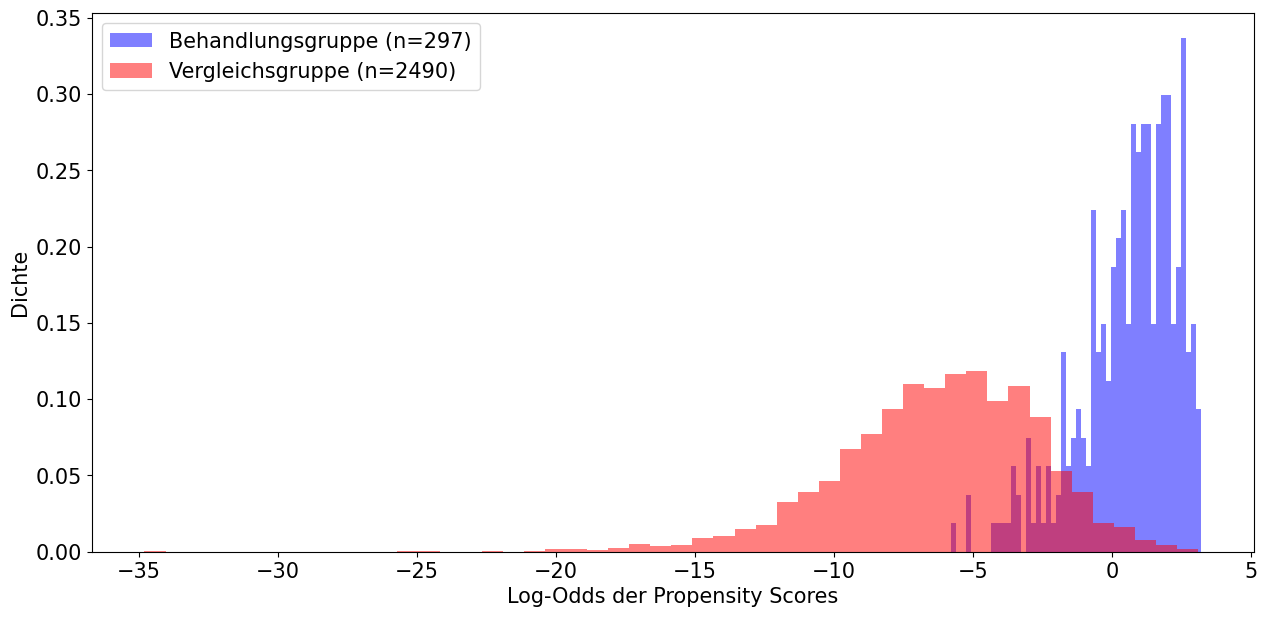

In [22]:
# Seed für die Reproduzierbarkeit festlegen
np.random.seed(1234)

# Kovariaten in den Lalonde-PSID-Daten auswählen
l_psid_d = l_psid.treat
l_psid_X = l_psid[["age", "education", "black", "hispanic", "married","nodegree", "re75", "u75"]]

# Propensity Scores mittels logistischer Regression mit Kreuzvalidierung schätzen
logistic_model = LogisticRegressionCV()
logistic_model.fit(l_psid_X, l_psid_d)
l_psid['ps_lr'] = logistic_model.predict_proba(l_psid_X)[:, 1]
# Log-Odds der Propensity Scores berechnen
l_psid['log_odds_ps_lr'] = np.log(l_psid['ps_lr'] / (1 - l_psid['ps_lr']))
# Anzahl der Beobachtungen in der Behandlungs- und Kontrollgruppe berechnen
count_treated = l_psid.loc[l_psid['treat'] == 1].shape[0]
count_untreated = l_psid.loc[l_psid['treat'] == 0].shape[0]

# Verteilung der Log-Odds der Propensity Scores in den beiden Gruppen plotten
plt.figure(figsize=(15, 7))
plt.hist(l_psid[l_psid['treat'] == 1]['log_odds_ps_lr'], bins=50, alpha=0.5, color='blue', label=f'Behandlungsgruppe (n={count_treated})', density=True)
plt.hist(l_psid[l_psid['treat'] == 0]['log_odds_ps_lr'], bins=50, alpha=0.5, color='red', label=f'Vergleichsgruppe (n={count_untreated})', density=True)
plt.xlabel('Log-Odds der Propensity Scores', fontsize=15)
plt.ylabel('Dichte', fontsize=15)
# Schriftgröße der Achsenticks anpassen
plt.tick_params(axis='both', labelsize=15)
plt.legend(fontsize=15, loc='upper left')
plt.show()

### Schätzung des Trainingseffekts auf das Einkommen mit DoubleML

### Truncation

In [23]:
# Entfernen der Spalten mit Propensity Scores und Log-Odds der Propensity Scores
l_cps = l_cps.drop(['ps_lr', 'log_odds_ps_lr'], axis=1).reset_index(drop=True)
l_psid = l_psid.drop(['ps_lr', 'log_odds_ps_lr'], axis=1).reset_index(drop=True)

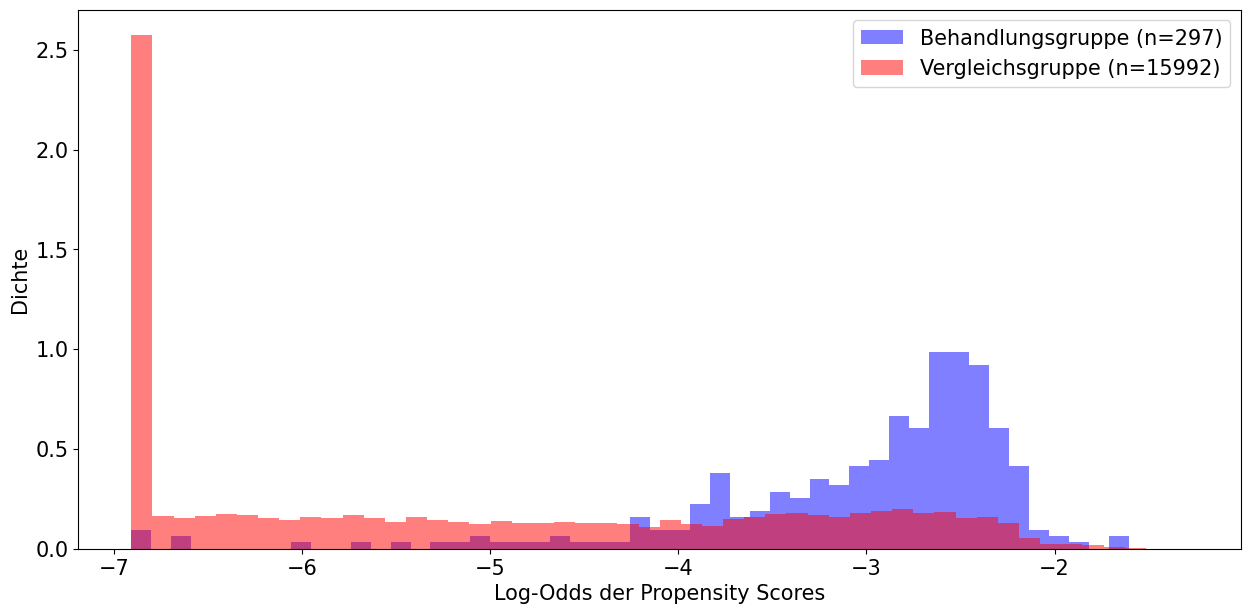

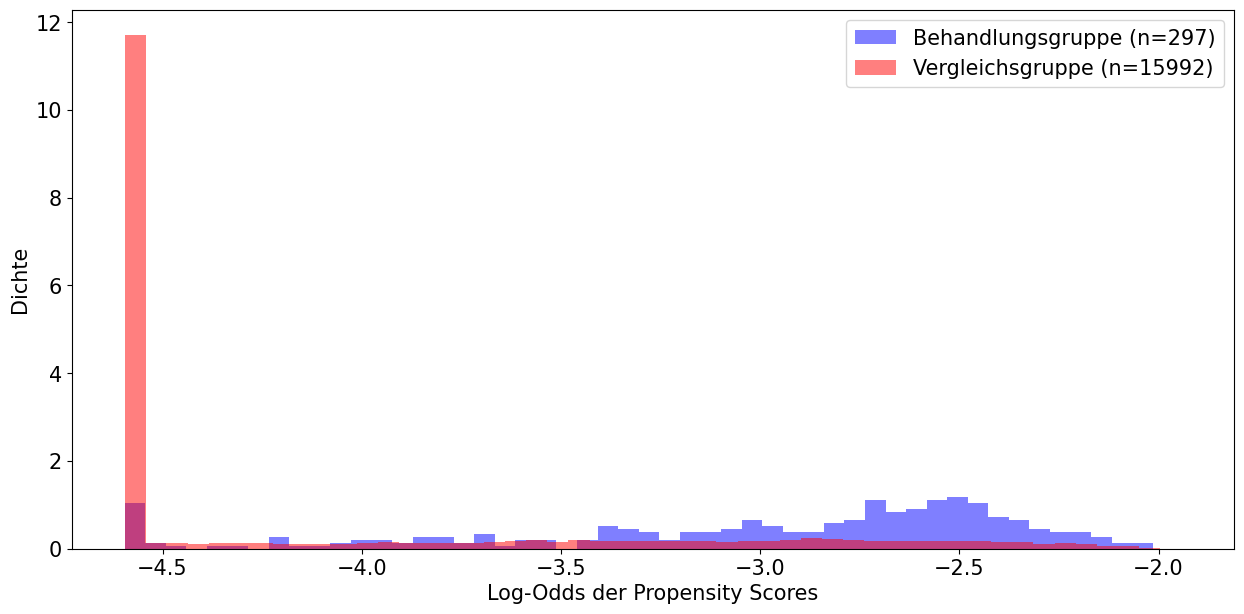

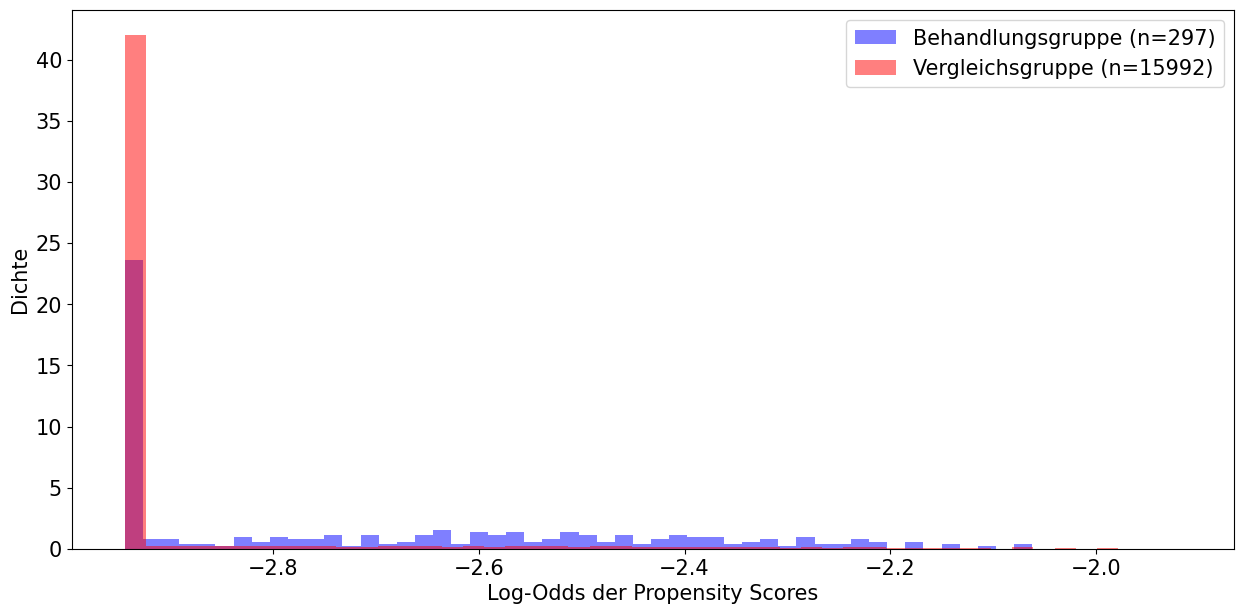

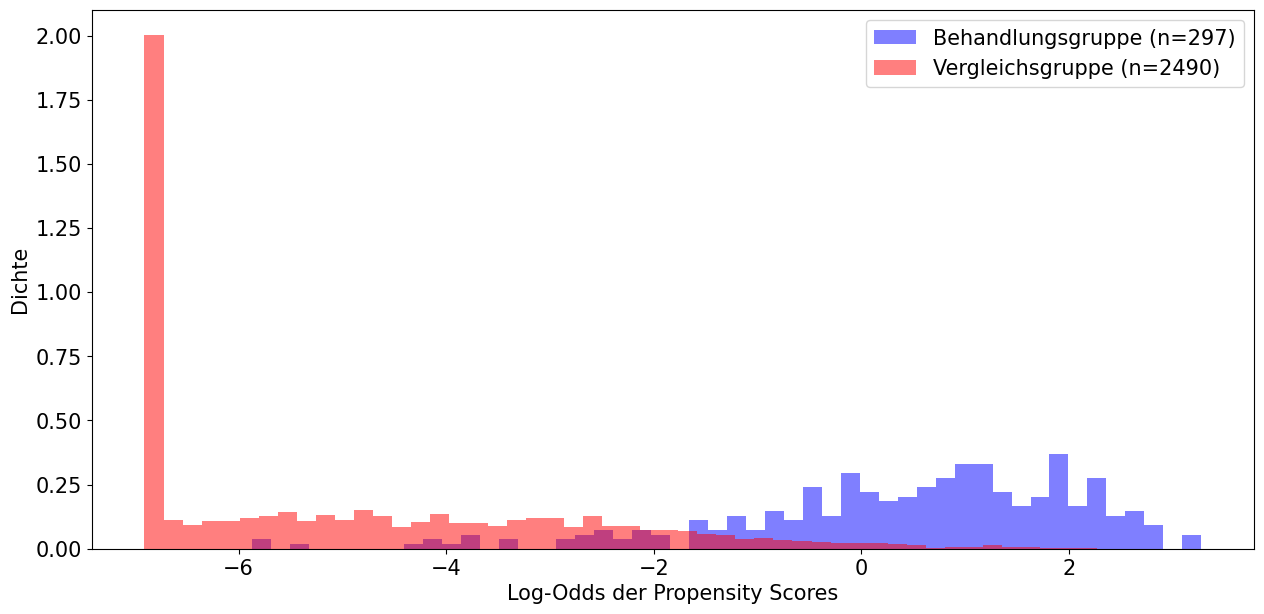

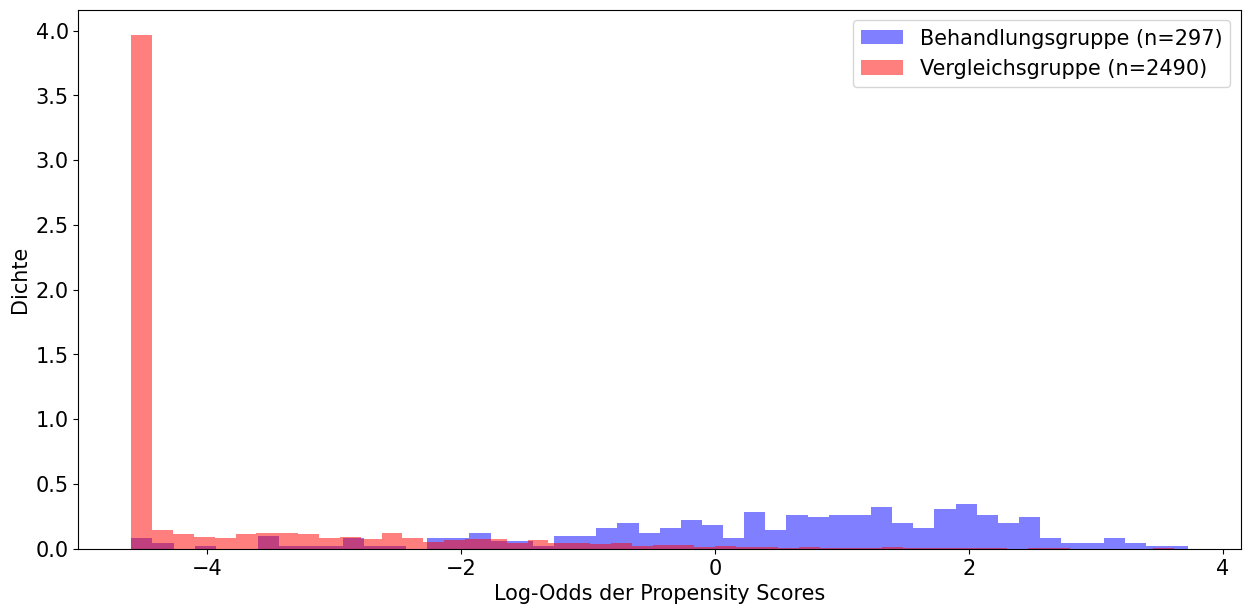

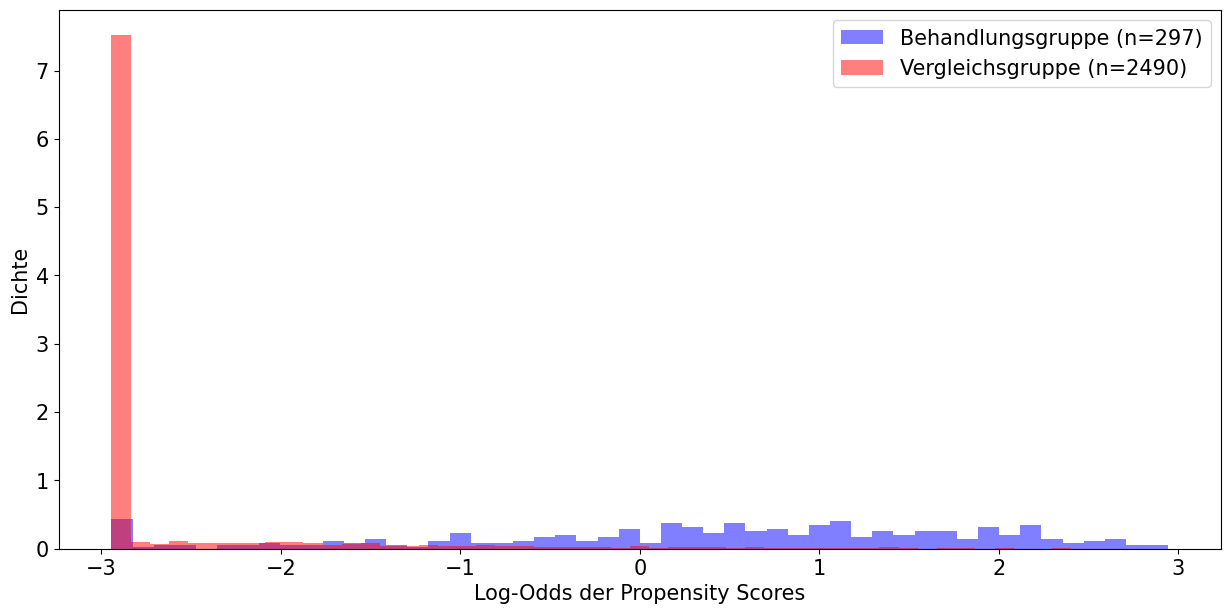

In [ ]:
# Seed für die Reproduzierbarkeit setzen
np.random.seed(1234)
# Liste für die Ergebnisse initialisieren
results_l_cps_trunc = []
results_l_psid_trunc = []
# Modelle für die Schätzung der Nuisance-Parameter initialisieren
ml_g, ml_m = LinearRegression(), LogisticRegressionCV()
# ATTE mit DML und mit verschiedenen Trimming Schwellenwerten für Lalonde-CPS und Lalonde-PSID schätzen
for df, res_name in zip([l_cps, l_psid], ['Lalonde-CPS', 'Lalonde-PSID']):
    data = DoubleMLData(df, 're78', 'treat', x_cols=["age", "education", "black", "hispanic", "married","nodegree", "re75", "u75"])
    for trim_value in [0.001, 0.01, 0.05]:
        dml_obj = DoubleMLIRM(data, ml_g, ml_m, trimming_threshold=trim_value, score='ATTE')
        dml_obj.fit()
        dml_summary = dml_obj.summary
        dml_summary['trim_value'] = trim_value
        dml_summary['share_trimmed_top'] = (((dml_obj.predictions['ml_m'].flatten() == (1-trim_value)).sum())/df.shape[0])*100
        dml_summary['share_trimmed_bottom'] = (((dml_obj.predictions['ml_m'].flatten() == trim_value).sum())/df.shape[0])*100
        dml_summary['treated'] = ((df.loc[df['treat'] == 1].sum())/df.shape[0])*100
        pscore = dml_obj.predictions['ml_m'].flatten()

        # Ergebnisse in die entsprechende Liste speichern
        if df.equals(l_cps):
            results_l_cps_trunc.append(dml_summary)
        else:
            results_l_psid_trunc.append(dml_summary)

        # Anzahl der Beobachtungen in der Behandlungs- und Kontrollgruppe berechnen
        count_treated = df.loc[df['treat'] == 1].shape[0]
        count_untreated = df.loc[df['treat'] == 0].shape[0]
        # Log-Odds der Propensity Scores berechnen
        df['log_odds'] = np.log(pscore / (1 - pscore))
        
        # Verteilung der Log-Odds der Propensity Scores in den beiden Gruppen plotten
        plt.figure(figsize=(15, 7))
        plt.hist(df[df['treat'] == 1]['log_odds'], bins=50, alpha=0.5, color='blue', label=f'Behandlungsgruppe (n={count_treated})', density=True)
        plt.hist(df[df['treat'] == 0]['log_odds'], bins=50, alpha=0.5, color='red', label=f'Vergleichsgruppe (n={count_untreated})', density=True)
        plt.tick_params(axis='both', labelsize=15)
        plt.xlabel('Log-Odds der Propensity Scores', fontsize=15)
        plt.ylabel('Dichte', fontsize=15)      
        plt.legend(fontsize=15, loc='upper right')
        plt.show()
            
# Ergebnisse zusammenfassen
l_cps_trunc = pd.concat(results_l_cps_trunc)
l_psid_trunc = pd.concat(results_l_psid_trunc)

### Discarding

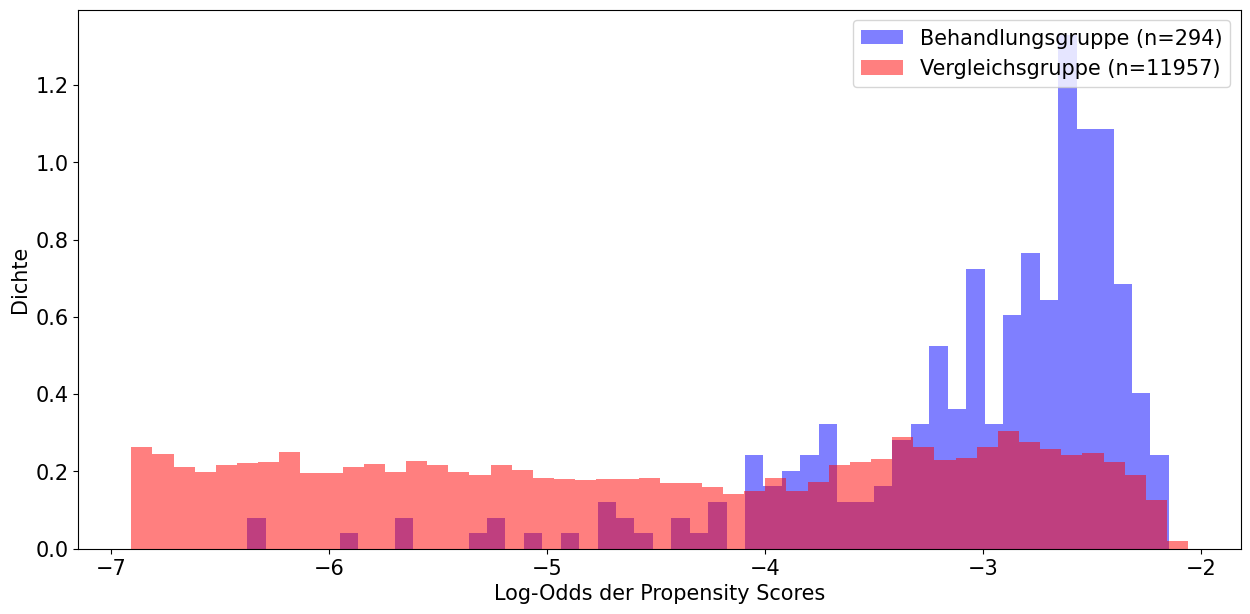

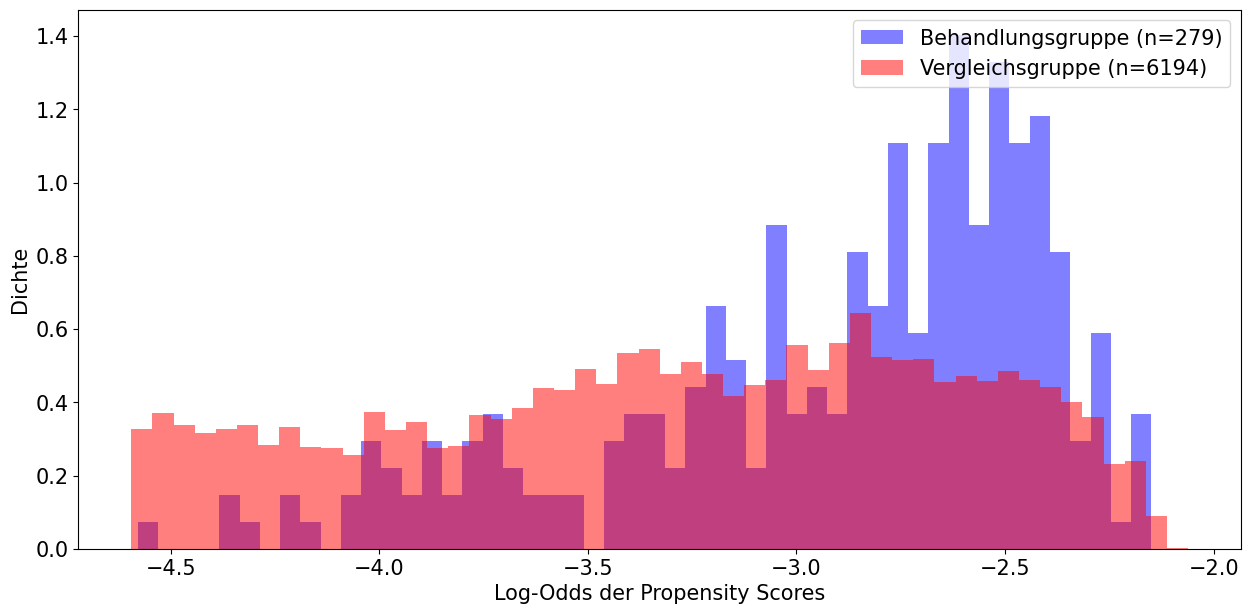

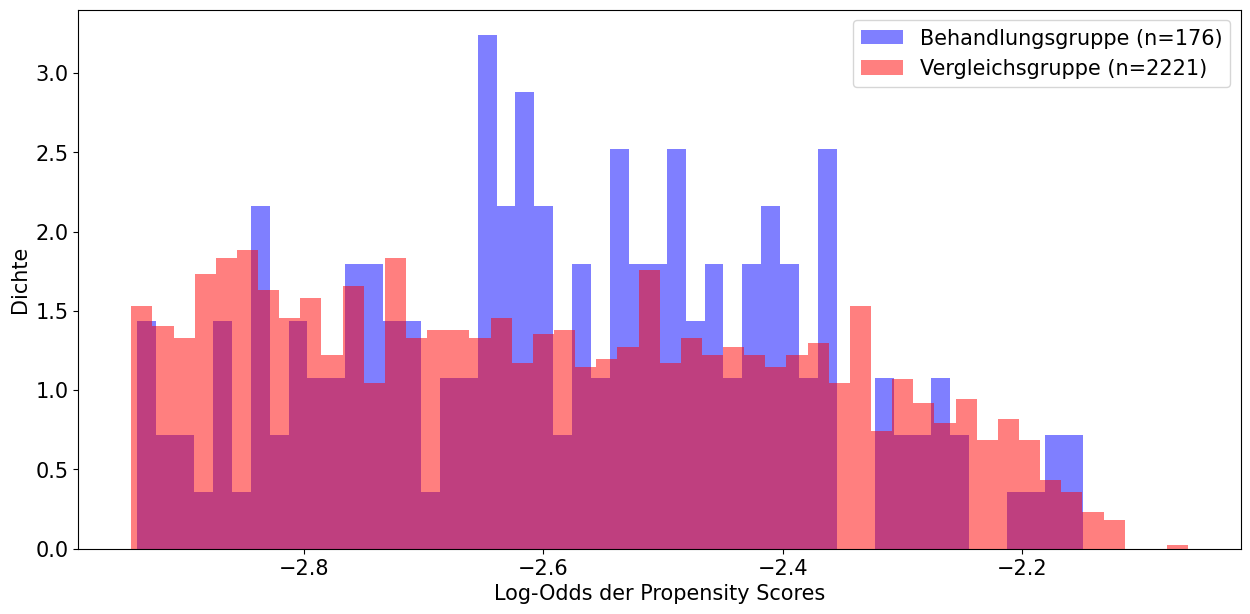

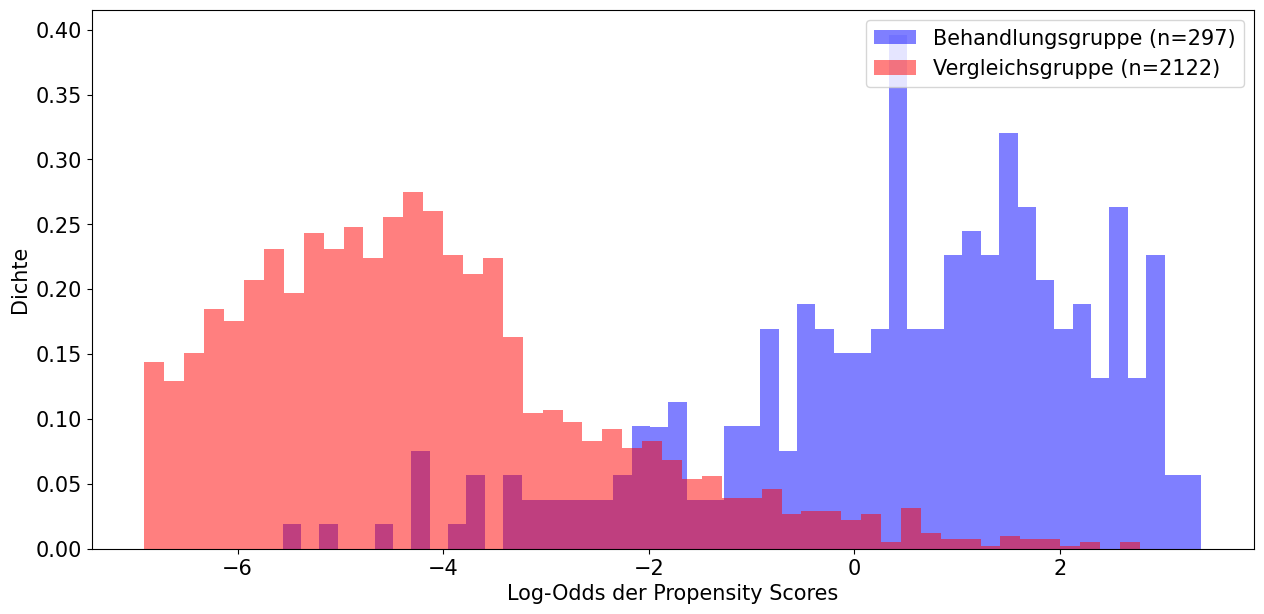

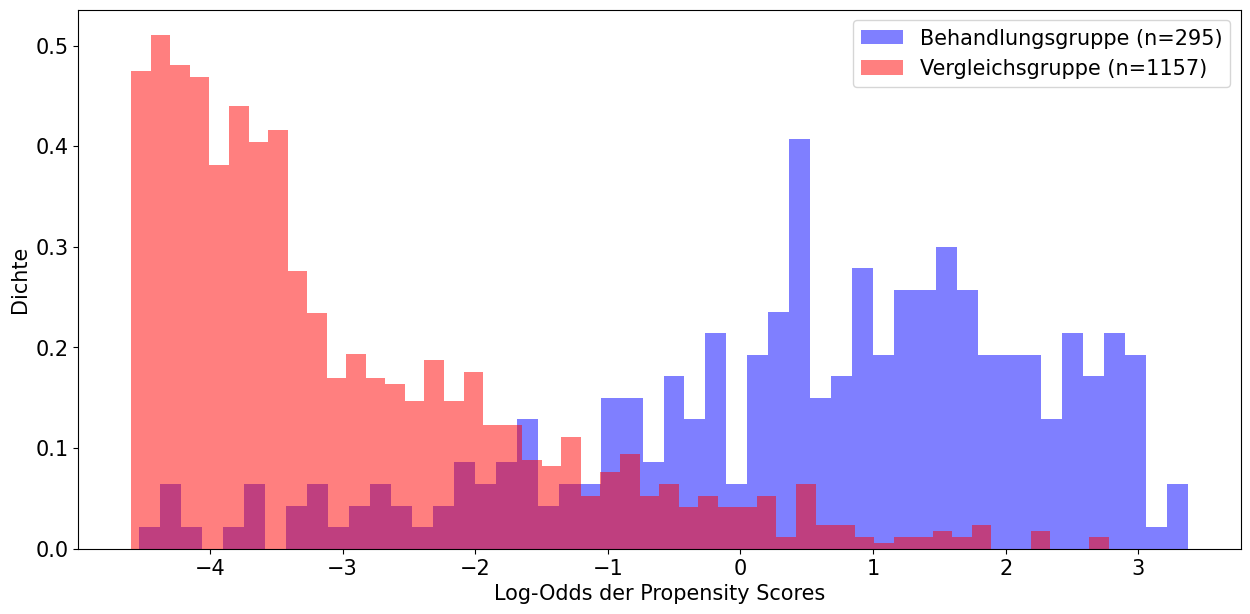

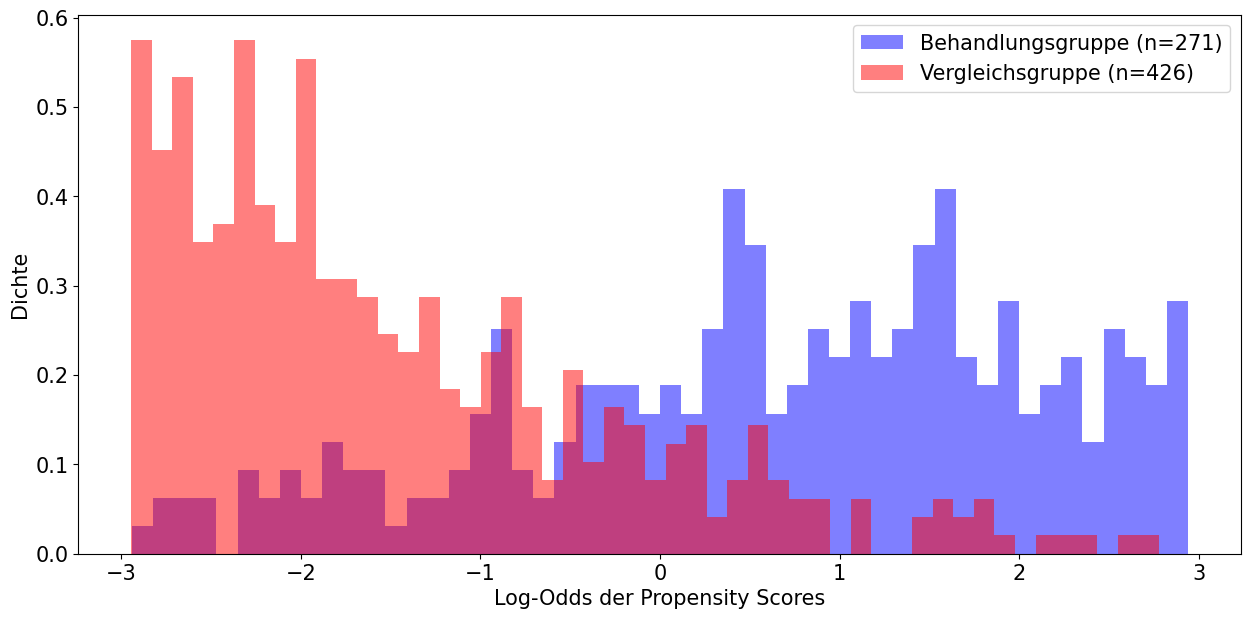

In [ ]:
# Seed für die Reproduzierbarkeit festlegen
np.random.seed(1234)

# Liste für die Ergebnisse initialisieren
results_l_cps_discard = []
results_l_psid_discard = []

# ATTE mit DML und mit verschiedenen Trimming Schwellenwerten für Lalonde-CPS und Lalonde-PSID schätzen
for df, res_name in zip([l_cps, l_psid], ['Lalonde-CPS', 'Lalonde-PSID']):
    n = df.shape[0]
    ml_g, ml_m = LinearRegression(), LogisticRegressionCV()
    data = df    

    # Cross-Fitting
    resampling_obj = DoubleMLResampling(n_folds=5, n_rep=1, n_obs=n, stratify=data.treat)
    smpls = resampling_obj.split_samples()

    # Propensity Scores schätzen
    pscore_est = cross_val_predict(ml_m, data.drop(['treat', 're78'], axis=1), data.treat, method='predict_proba', cv=resampling_obj.resampling)[:,1]
    

    for trim_value in [0.001, 0.01, 0.05]:
        smpls_new, data_trimmed, pscore_trimmed = pscore_discard(data, pscore_est, smpls, trim_value)  

        # DML Data Objekt erstellen        
        dml_data = DoubleMLData.from_arrays(x=data_trimmed.drop(columns=['treat', 're78']), y=data_trimmed['re78'], d=data_trimmed['treat'])
        dml_obj = DoubleMLIRM(dml_data, ml_g, ml_m, trimming_threshold=1e-12, draw_sample_splitting = False, score='ATTE')
        dml_obj.set_sample_splitting(smpls_new)
        dml_obj.fit(external_predictions={"d": {"ml_m": pscore_trimmed}})
        dml_summary = dml_obj.summary
        dml_summary['trim_value'] = trim_value
        dml_summary['share_trimmed_top'] =  ((np.where(pscore_est >= (1-trim_value), 1, 0).sum())/pscore_est.shape[0])*100
        dml_summary['share_trimmed_bottom'] = ((np.where(pscore_est <= trim_value, 1, 0).sum())/pscore_est.shape[0])*100
        dml_summary['treated'] = (((data_trimmed['treat'] == 1).sum())/data_trimmed.shape[0])*100

        pscore = pscore_trimmed.flatten()      
        # Log-Odds der Propensity Scores berechnen  
        data_trimmed['log_odds'] = np.log(pscore / (1 - pscore))      

        # Ergebnisse in die entsprechende Liste speichern
        if df.equals(l_cps):
            results_l_cps_discard.append(dml_summary)
        else:
            results_l_psid_discard.append(dml_summary)

        # Anzahl der Beobachtungen in der Behandlungs- und Kontrollgruppe berechnen
        count_treated = data_trimmed.loc[data_trimmed['treat'] == 1].shape[0]
        count_untreated = data_trimmed.loc[data_trimmed['treat'] == 0].shape[0]

        # Verteilung der Log-Odds der Propensity Scores in den beiden Gruppen plotten
        plt.figure(figsize=(15, 7))
        plt.hist(data_trimmed[data_trimmed['treat'] == 1]['log_odds'], bins=50, alpha=0.5, color='blue', label=f'Behandlungsgruppe (n={count_treated})', density=True)
        plt.hist(data_trimmed[data_trimmed['treat'] == 0]['log_odds'], bins=50, alpha=0.5, color='red', label=f'Vergleichsgruppe (n={count_untreated})', density=True)
        plt.tick_params(axis='both', labelsize=15)
        plt.xlabel('Log-Odds der Propensity Scores', fontsize=15)
        plt.ylabel('Dichte', fontsize=15)      
        plt.legend(fontsize=15, loc='upper right')
        plt.show()

# Ergebnisse als DataFrame zusammenfassen
l_cps_discard = pd.concat(results_l_cps_discard)
l_psid_discard = pd.concat(results_l_psid_discard)

In [ ]:
# Ergebnisse für Lalonde-CPS-Daten ausgeben - Truncation
print('L-CPS-Truncation:')
l_cps_trunc

L-CPS-Truncation:


,coef,std err,t,P>|t|,2.5 %,97.5 %,trim_value,share_trimmed_top,share_trimmed_bottom,treated
treat,-890.427714,464.744674,-1.915950,0.055371,-1801.310538,20.455110,0.001,0.0,26.686721,1.823316
treat,-896.127698,463.628866,-1.932856,0.053254,-1804.823577,12.568181,0.010,0.0,60.341335,1.823316
treat,-816.925424,484.210657,-1.687128,0.091579,-1765.960873,132.110026,0.050,0.0,85.038983,1.823316


In [ ]:
# Ergebnisse für Lalonde-CPS-Daten ausgeben - Discarding
print('L-CPS und Discarding:')
l_cps_discard

L-CPS und Discarding:


,coef,std err,t,P>|t|,2.5 %,97.5 %,trim_value,share_trimmed_top,share_trimmed_bottom,treated
d,-479.412841,451.956078,-1.060751,0.288803,-1365.230476,406.404794,0.001,0.0,24.789735,2.399804
d,159.625214,451.870229,0.353255,0.723898,-726.024162,1045.274589,0.010,0.0,60.261526,4.310212
d,953.804782,578.274989,1.649397,0.099066,-179.593370,2087.202933,0.050,0.0,85.284548,7.342511


In [ ]:
# Ergebnisse für Lalonde-PSID-Daten ausgeben - Truncation
print('L-PSID und Truncation:')
l_psid_trunc

L-PSID und Truncation:


,coef,std err,t,P>|t|,2.5 %,97.5 %,trim_value,share_trimmed_top,share_trimmed_bottom,treated
treat,-1203.783988,717.507409,-1.677730,0.093400,-2610.072668,202.504691,0.001,0.000000,31.395766,10.65662
treat,-367.287449,880.761159,-0.417011,0.676670,-2093.547599,1358.972702,0.010,0.000000,56.476498,10.65662
treat,-1330.418584,740.182529,-1.797420,0.072269,-2781.149682,120.312515,0.050,0.035881,71.510585,10.65662


In [ ]:
# Ergebnisse für Lalonde-PSID-Daten ausgeben - Discarding
print('L-PSID-Discarding:')
l_psid_discard

L-PSID-Discarding:


,coef,std err,t,P>|t|,2.5 %,97.5 %,trim_value,share_trimmed_top,share_trimmed_bottom,treated
d,-1244.291111,879.228457,-1.415208,0.157008,-2967.547221,478.964999,0.001,0.000000,13.204162,12.277801
d,-1028.146118,876.175398,-1.173448,0.240616,-2745.418343,689.126107,0.010,0.000000,47.900969,20.316804
d,-157.909701,1008.433517,-0.156589,0.875569,-2134.403075,1818.583673,0.050,0.322928,74.668102,38.880918


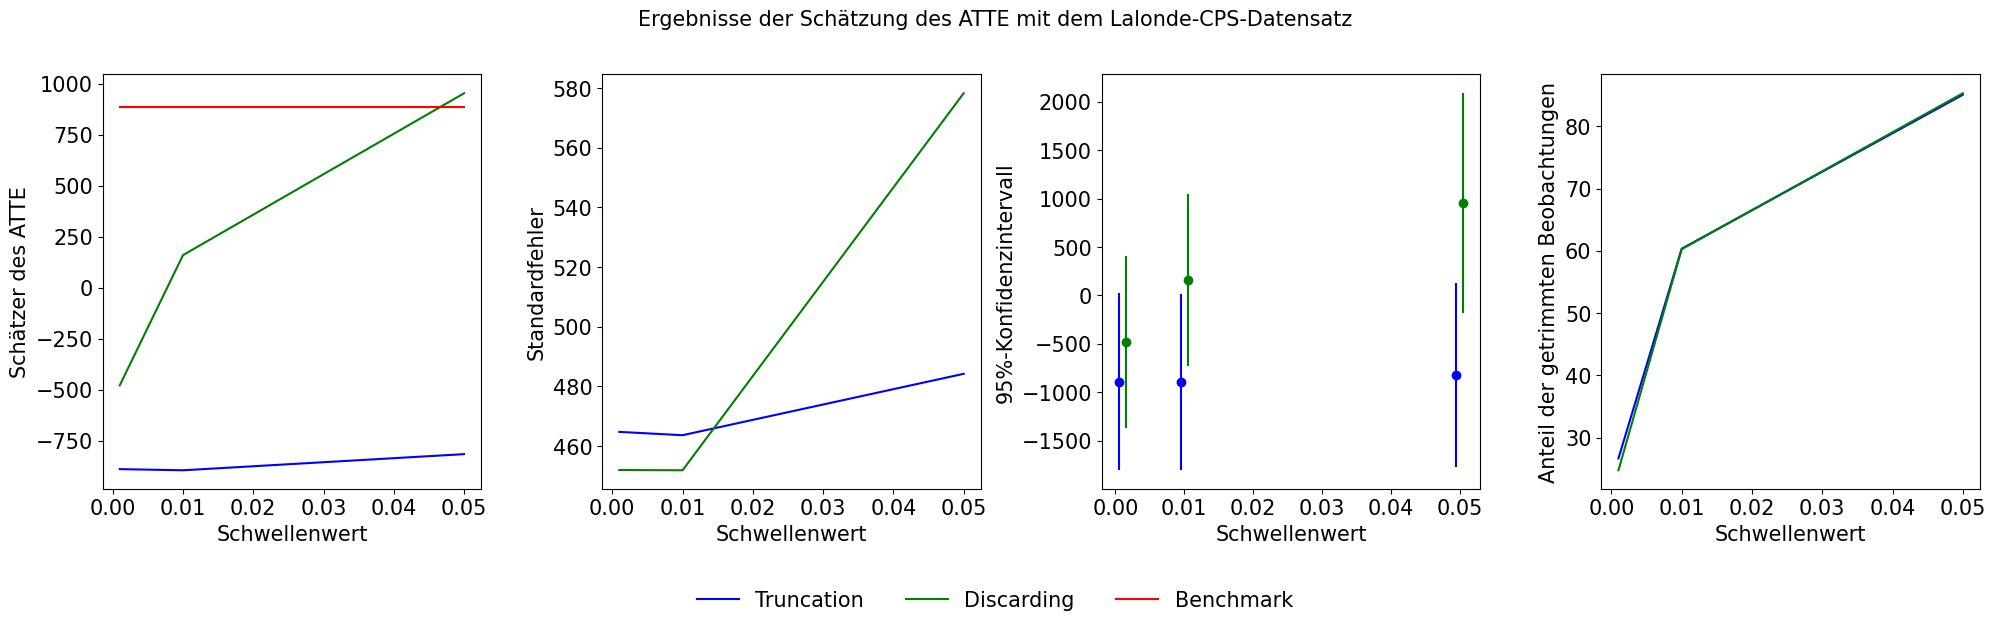

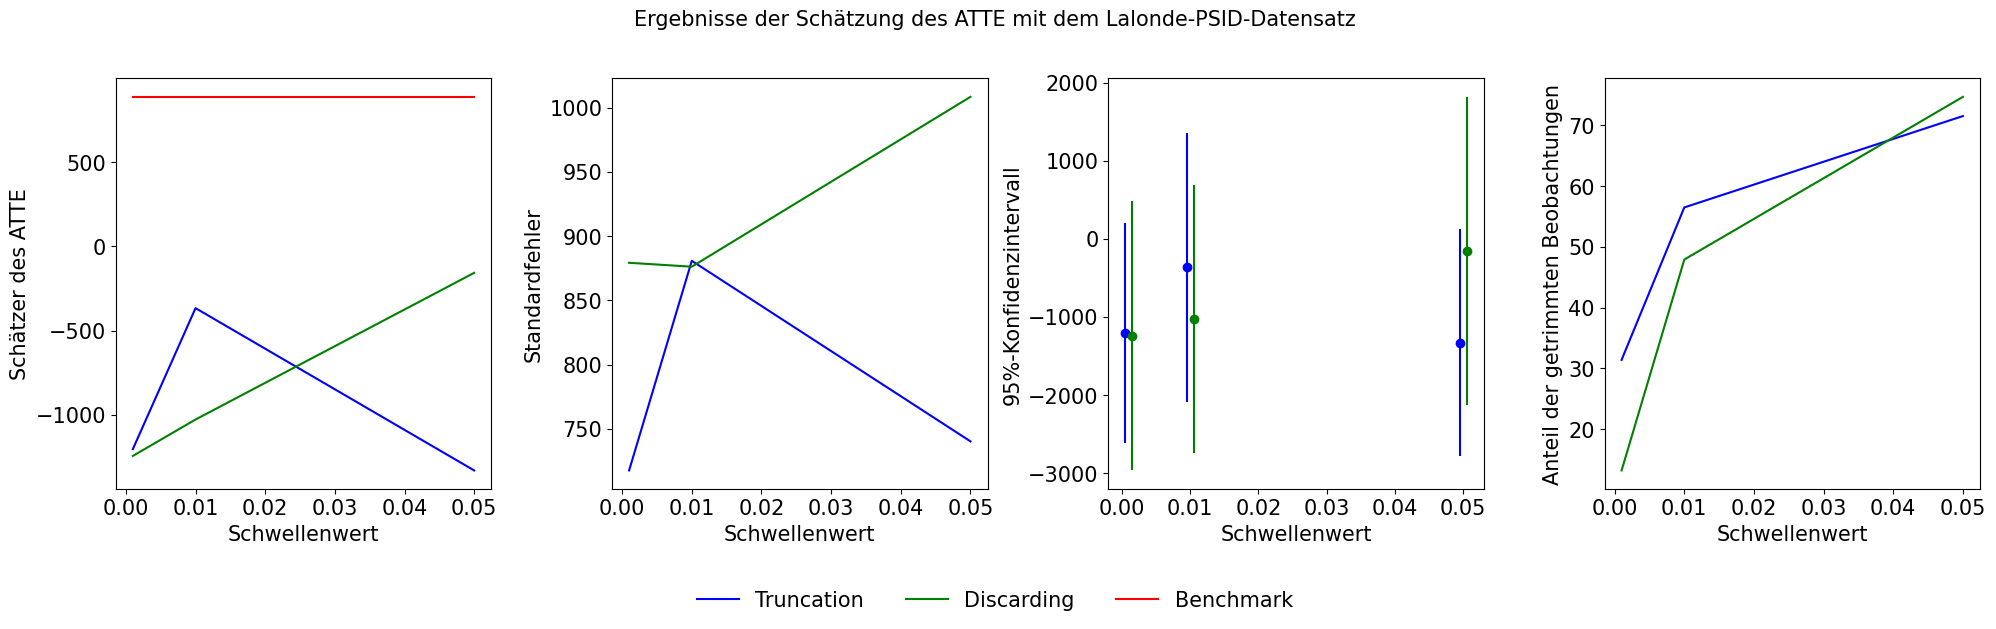

In [ ]:
# Visualisierung der Ergebnisse
df_csp = [l_cps_trunc, l_cps_discard]
df_psid = [l_psid_trunc, l_psid_discard]

for df, res_name in zip([df_csp, df_psid], ['Lalonde-CPS', 'Lalonde-PSID']):           
    fig, ax = plt.subplots(1, 4, figsize=(20, 5))
    trim_values = df[0]['trim_value'].unique()
    df_trunc = df[0]
    df_discard = df[1]

    # Schriftgröße für die Achsenbeschriftung
    for a in ax:
        a.tick_params(axis='both', labelsize=15)

    # Plot für den Schätzer des ATTE
    ax[0].plot(trim_values, df_trunc['coef'] , label='Truncation', color='blue')
    ax[0].plot(trim_values, df_discard['coef'] , label='Discarding', color='green')
    ax[0].plot(trim_values, [benchmark] * len(trim_values), label='Benchmark', color='red')
    ax[0].set_xlabel('Schwellenwert', fontsize=15)
    ax[0].set_ylabel('Schätzer des ATTE', fontsize=15)

    # Plot für den Standardfehler
    ax[1].plot(trim_values, df_trunc['std err'], label='Truncation', color='blue')
    ax[1].plot(trim_values, df_discard['std err'], label='Discarding', color='green')
    ax[1].set_xlabel('Schwellenwert', fontsize=15)
    ax[1].set_ylabel('Standardfehler', fontsize=15)

    # Plot für den 95%-Konfidenzintervall
    # Leichte Verschiebung der Werte für Truncation und Discarding, um die CI zu trennen
    offset = 0.0005
    trim_values_trunc = trim_values - offset
    trim_values_discard = trim_values + offset
    ax[2].errorbar(trim_values_trunc, df_trunc['coef'], yerr=1.96*df_trunc['std err'], fmt='o', color='blue')
    ax[2].errorbar(trim_values_discard, df_discard['coef'], yerr=1.96*df_discard['std err'], fmt='o', color='green')
    ax[2].set_xlabel('Schwellenwert', fontsize=15)
    ax[2].set_ylabel('95%-Konfidenzintervall', fontsize=15)

    # # Anteil der getrimmten Beobachtungen
    ax[3].plot(trim_values, df_trunc['share_trimmed_bottom'], label='Truncation', color='blue')
    ax[3].plot(trim_values, df_discard['share_trimmed_bottom'], label='Discarding', color='green')
    ax[3].set_xlabel('Schwellenwert', fontsize=15)
    ax[3].set_ylabel('Anteil der getrimmten Beobachtungen', fontsize=15)

    # Legende erstellen
    handles = [
        Line2D([0], [0], color='blue', label='Truncation'),
        Line2D([0], [0], color='green', label='Discarding'),
        Line2D([0], [0], color='red', label='Benchmark')]
    
    # Legende korrekt platzieren
    fig.legend(handles=handles, loc='lower center', fontsize=15, bbox_to_anchor=(0.5, -0.14), ncols=4, frameon=False)

    # Layout anpassen und anzeigen
    plt.tight_layout()    
    plt.suptitle(f'Ergebnisse der Schätzung des ATTE mit dem {res_name}-Datensatz', fontsize=15, y=1.1)
    plt.show()

In [ ]:
# Breite des Konfidenzintervalls berechnen - Lalonde-CPS-Daten - Truncation
print('L-CPS-Truncation:')
l_cps_trunc['97.5 %']-l_cps_trunc['2.5 %']

L-CPS-Truncation:


treat    1821.765648
treat    1817.391758
treat    1898.070899
dtype: float64

In [ ]:
# Breite des Konfidenzintervalls berechnen - Lalonde-CPS-Daten - Discarding
print('L-CPS-Discarding:')
l_cps_discard['97.5 %']-l_cps_discard['2.5 %']

L-CPS-Discarding:


d    1771.635271
d    1771.298751
d    2266.796303
dtype: float64

In [ ]:
# Breite des Konfidenzintervalls berechnen - Lalonde-PSID-Daten - Discarding
print('L-PSID-Truncation:')
l_psid_trunc['97.5 %']-l_psid_trunc['2.5 %']

L-PSID-Truncation:


treat    2812.577359
treat    3452.520301
treat    2901.462197
dtype: float64

In [ ]:
# Breite des Konfidenzintervalls berechnen - Lalonde-PSID-Daten - Discarding
print('L-PSID-Discarding:')
l_psid_discard['97.5 %']-l_psid_discard['2.5 %']


L-PSID-Discarding:


d    3446.512220
d    3434.544450
d    3952.986749
dtype: float64